# Label side

In [2]:
import numpy as np
from jesse import helpers, research

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2022-07-01"),
    helpers.date_to_timestamp("2025-07-25"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

candles.shape

(1612800, 6)

In [3]:
np.save("data/btc_1m.npy", candles)
del candles

In [1]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles.shape

(1657440, 6)

In [2]:
from src.bars.fusion.deap_v1 import DeapBarV1

bar_container = DeapBarV1(max_bars=500000)
bar_container.update_with_candles(candles)
merged_bar = bar_container.get_fusion_bars()
merged_bar.shape

(5789, 6)

In [5]:
from research.labeler.gmm_labeler import GMMLabeler

labeler = GMMLabeler(merged_bar, 4)
labeler.plot_label_on_candles()

[I 2025-09-04 16:05:35,439] A new study created in memory with name: no-name-4a066d1a-f231-43bb-880b-6731fe17302a
[I 2025-09-04 16:05:36,348] Trial 0 finished with value: 30.109392269606634 and parameters: {'random_state': 512}. Best is trial 0 with value: 30.109392269606634.
[I 2025-09-04 16:05:36,910] Trial 1 finished with value: 24.328785532080833 and parameters: {'random_state': 779}. Best is trial 0 with value: 30.109392269606634.
[I 2025-09-04 16:05:37,425] Trial 2 finished with value: 1.770435851529439 and parameters: {'random_state': 171}. Best is trial 0 with value: 30.109392269606634.
[I 2025-09-04 16:05:38,120] Trial 3 finished with value: 24.365745899492794 and parameters: {'random_state': 810}. Best is trial 0 with value: 30.109392269606634.
[I 2025-09-04 16:05:38,691] Trial 4 finished with value: 24.38473846382223 and parameters: {'random_state': 781}. Best is trial 0 with value: 30.109392269606634.
[I 2025-09-04 16:05:39,418] Trial 5 finished with value: 1.77043585152943

state 0 (3022) return: 1593.991406%
state 1 (2763) return: -1416.947821%


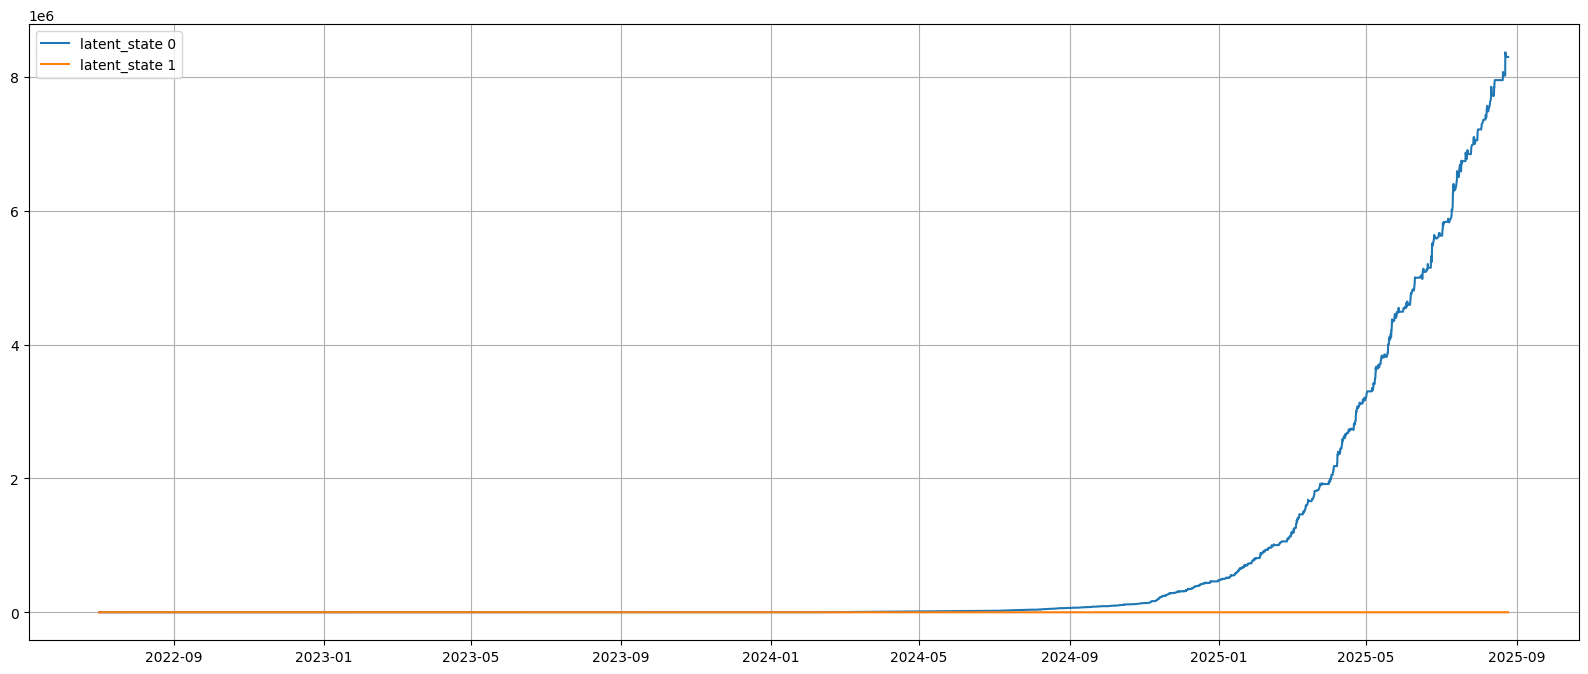

In [6]:
labeler.plot_label_returns()

In [ ]:
# TODO: 加工新的label

In [11]:
# 保存merged bar, 去除最后一个bar，因为需要label前移一位
print(merged_bar[:-1].shape)
np.save("data/merged_bar.npy", merged_bar[:-1])

(15063, 6)


In [12]:
# 上涨下跌统一打标的情况

label = (latent_states_sequence == 0).astype(int)
print(label.shape)
print(np.unique(label, return_counts=True))
np.save("data/side_label.npy", label)

(15059,)
(array([0, 1]), array([5798, 9261]))


In [ ]:
# 上涨下跌分别打标的情况

# label_long = (latent_states_sequence == 1).astype(int)
# print(np.unique(label_long, return_counts=True))
# np.save("data/side_label_long.npy", label_long)

# label_short = (latent_states_sequence == 0).astype(int)
# print(np.unique(label_short, return_counts=True))
# np.save("data/side_label_short.npy", label_short)

# Label meta

In [1]:
import numpy as np
import pandas as pd
from strategies.BinanceBtcEntropyBarV1.config import SIDE
from strategies.BinanceBtcEntropyBarV1.config import get_side_model

side_model = get_side_model(False)

merged_bar = np.load("data/merged_bar.npy")

df_features = pd.read_parquet("data/features.parquet")

side_res = side_model.predict(df_features[SIDE])

side_pred_label = np.where(side_res > 0.5, 1, -1)
print(side_pred_label.shape)

print(np.unique(side_pred_label, return_counts=True))

(13219,)
(array([-1,  1]), array([5080, 8139]))


In [2]:
close_prices = merged_bar[:, 2]
len_gap = len(close_prices) - len(side_pred_label)
close_prices = close_prices[len_gap - 1 : -1]

assert len(close_prices) == len(side_pred_label)

In [3]:
meta_label = np.zeros(len(side_pred_label))

TRADE_FEE = 0.05 / 100

start_idx = 0
cumsum_ret = 0
start_price = 0
for idx, (i, p) in enumerate(zip(side_pred_label, close_prices)):
    if i == 1 or i == -1:
        if idx == 0:
            # 开始持仓
            start_idx = idx
            start_price = p
            cumsum_ret -= TRADE_FEE
        elif side_pred_label[idx - 1] != i:
            # 反向持仓，先结算收益
            cumsum_ret -= TRADE_FEE
            cumsum_ret += np.log(p / start_price) * side_pred_label[idx - 1]
            if cumsum_ret > 0:
                meta_label[start_idx:idx] = 1
            cumsum_ret = 0
            start_price = p
            start_idx = idx
            cumsum_ret -= TRADE_FEE
        else:
            # 继续持仓
            continue
    else:
        raise ValueError(f"side_pred_label[{idx}] = {i} is not valid")
else:
    last_price = merged_bar[-1, 2]
    # 结算最后一根bar的持仓, 可能还没有结算，所以先不加trade fee
    if i == side_pred_label[idx - 1]:
        # 已经开仓，结算
        cumsum_ret += np.log(last_price / start_price) * side_pred_label[idx - 1]
        if cumsum_ret > 0:
            meta_label[start_idx:] = 1
    else:
        # 反向开仓
        cumsum_ret -= TRADE_FEE
        cumsum_ret += np.log(last_price / start_price) * side_pred_label[idx - 1]
        if cumsum_ret > 0:
            meta_label[start_idx:] = 1


print(np.unique(meta_label, return_counts=True))

(array([0., 1.]), array([  669, 12550]))


In [4]:
np.save("data/label_meta.npy", meta_label)